# Otimização de Lavra Mineral através do Sequenciamento Direto de Blocos.
Por: Thalles Morais

Este notebook tem a intenção de propor um ambiente didático, onde seja possível o acesso a alguns dos algoritmos utilizados em softwares de planejamento de lavra, de forma a contribuir com o entendimento dos mesmos. Os dados usados como input neste notebook referem-se a uma jazida modela em blocos e estão em uma tabela de 500 linhas onde cada linha possui informações de um bloco. 

O objetivo deste notebook é criar um algoritmo que retorne a sequência de blocos a serem extraídos por período que apresente maior lucro, considerando restrições de capacidade de mina, capacidade de usina e precedência de blocos. As restrições de capacidade de lavra e usina estão relacionadas à tonelagem de massa que podem ser extraídas e processadas em um ano e a restrição de precedência de bloco diz respeito a quais blocos devem ser extraídos para que outro também seja (considerando que alguns blocos estão posicionados acima de outros).

A célula abaixo importa as bibliotecas necessárias para realização deste trabalho.

In [1]:
!pip install numpy
!pip install pandas
!pip install gurobipy
!pip install miningpy

import numpy as np
import pandas as pd
import gurobipy as gp
from gurobipy import GRB
import miningpy

You should consider upgrading via the 'c:\users\thall\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\thall\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\thall\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'c:\users\thall\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


As colunas da tabela usada neste notebook referem-se às informações que cada bloco possui como massa, teor, densidade, ângulo de extração e suas coordenadas no espaço. Essas informações são fundamentais para determinar se um bloco deve ou não ser extraído e, caso seja, se ele deve ser destinado à usina ou para a pilha de estéril.

Abaixo podemos visualizar o banco de dados utilizando sendo importado e utilizado para criar um dataframe com as informações do mesmo.

In [2]:
df = pd.read_csv('./dataset.csv')
df = df[['ID', 'IX', 'IY', 'IZ', 'Teor', 'Densidade', 'Angulo', 'Massa', 'Usina', 'Pilha']]
ID = list(df['ID'].values)
i = list(df['IX'].values)
j = list(df['IY'].values)
k = list(df['IZ'].values)
Massa = list(df['Massa'].values)
Teor = list(df['Teor'].values)
Usina = list(df['Usina'].values)
Pilha = list(df['Pilha'].values)
index = ID
df['index'] = index
df.set_index('index', inplace = True)

comprimento = len(set(i))
largura = len(set(j))
altura = len(set(k))
area = int(comprimento*largura)
volume = int(comprimento*largura*altura)

df.head()

,ID,IX,IY,IZ,Teor,Densidade,Angulo,Massa,Usina,Pilha
index,,,,,,,,,,
1,1,1,1,1,0.0,2.85,45,2850,-14250.0,-2850
2,2,2,1,1,0.0,2.85,45,2850,-14250.0,-2850
3,3,3,1,1,0.0,2.85,45,2850,-14250.0,-2850
4,4,4,1,1,0.0,2.85,45,2850,-14250.0,-2850
5,5,5,1,1,0.0,2.85,45,2850,-14250.0,-2850


A célula abaixo cria duas listas: Massa_Processada e valor_bloco. Se um bloco apresenta maior valor na coluna Usina, sua massa é adicionada na lista Massa_Processada e seu valor de usina é acrescido na lista valor_bloco, caso contrário, será adicionado o valor de 0 para este bloco na lista Massa_Processada e seu valor de pilha é acrescido na lista valor_bloco. Após isso, as colunas Massa Processada e Valor do bloco são adicionadas ao dataframe com os valores contidos nas listas Massa_Processada e valor_bloco.

Em seguida são criados três dicionários: dici_massa, dici_min e dici_valor. Estes três dicionários relacionam a identidade de cada bloco com seus valores nas colunas Massa, Massa Processada e Valor do bloco.

In [3]:
Massa_Processada = []
valor_bloco = []
for n in range(volume):
    if Usina[n] > Pilha[n]:
        Massa_Processada.append(Massa[n])
        valor_bloco.append(Usina[n])
    else:
        Massa_Processada.append(0)
        valor_bloco.append(Pilha[n])
        
df['Massa Processada'] = Massa_Processada
df['Valor do bloco'] = valor_bloco

dici_massa = {}
dici_min = {}
dici_valor = {}
for p in range(volume):
    dici_massa[float(ID[p])] = Massa[p]
    dici_min[float(ID[p])] = Massa_Processada[p]
    dici_valor[float(ID[p])] = valor_bloco[p]

A célula abaixo cria listas que serão utilizadas para definir as restrições de precedência de blocos. Cada lista refere-se a uma posição em relação a um bloco b, onde para que seja possível remover este bloco b, é necessário antes remover os blocos posicionados acima dele. As figuras abaixo exibem as duas formas que este notebook pode realizar essa restrição, onde em ambos os casos o bloco vermelho é o que deseja ser extraído (bloco b). A figura à esquerda ilustra a situação 1 onde apenas cinco bloco (em azul) são necessários para extrair o bloco de interesse e a figura à direita exibe a situação 2 em que nove blocos (em azul) são necessários.

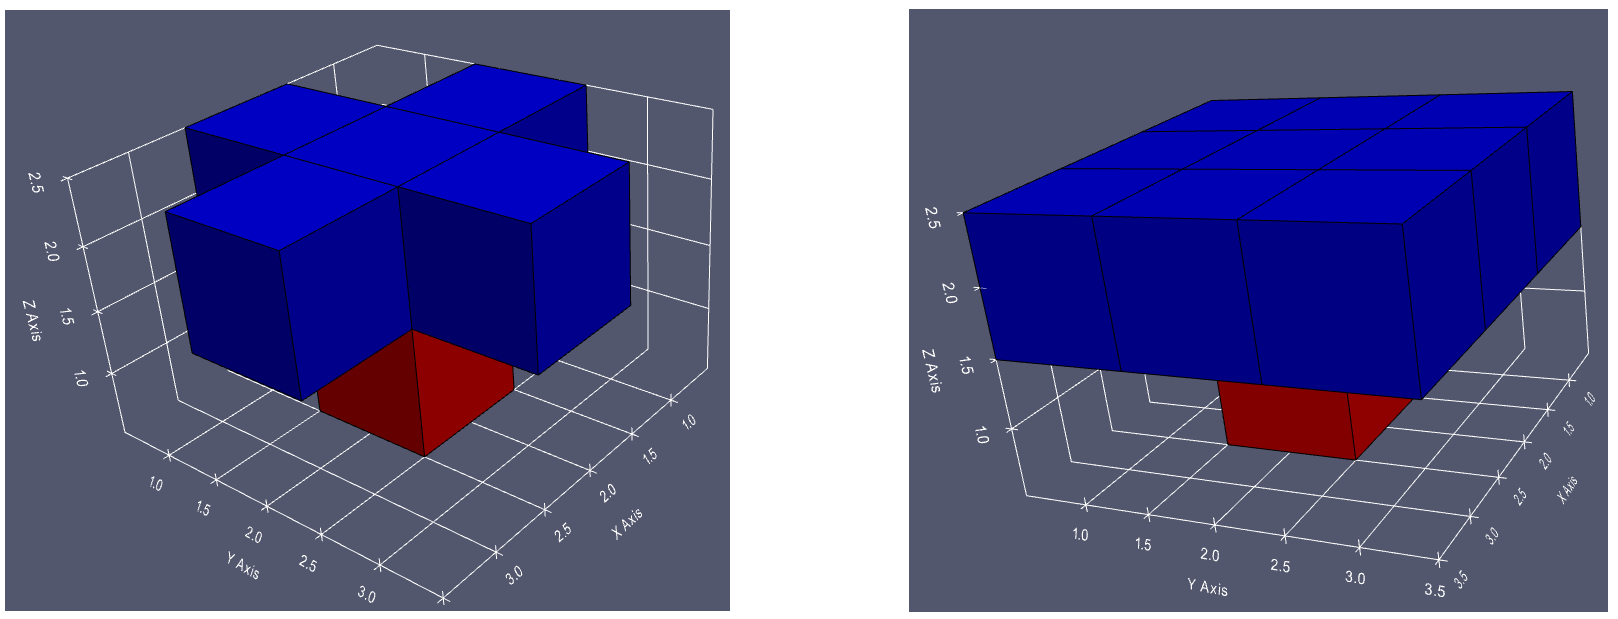

In [5]:
a = int(input('Digite a metodologia de precedência de blocos desejada: '))

Digite a metodologia de precedência de blocos desejada: 1


In [6]:
lista_todos_valores = []
for zuo in range(area+1, volume+1):
    lista_todos_valores.append(zuo)

lista_primeira_linha = []
for t in lista_todos_valores:
    if t % area > comprimento or t % area == 0:
        lista_primeira_linha.append(t)

lista_ultima_linha = []
for s in lista_todos_valores:
    if s % area <= (area - comprimento) and s % area != 0:
        lista_ultima_linha.append(s)

lista_primeira_coluna = []
for g in lista_todos_valores:
    if g % comprimento != 1:
        lista_primeira_coluna.append(g)
        
lista_última_coluna = []
for d in lista_todos_valores:
    if d % comprimento != 0:
        lista_última_coluna.append(d)

lista_diag_sup_esq = []
for o in lista_primeira_linha:
    if o % comprimento != 1:
        lista_diag_sup_esq.append(o)
        
lista_diag_inf_esq = []
for r in lista_ultima_linha:
    if r % comprimento != 1:
        lista_diag_inf_esq.append(r)

lista_diag_sup_dir = []
for y in lista_primeira_linha:
    if y % comprimento != 0:
        lista_diag_sup_dir.append(y)
        
lista_diag_inf_dir = []
for x in lista_ultima_linha:
    if x % comprimento != 0:
        lista_diag_inf_dir.append(x)

Os parâmetros econômicos e operacionais utilizados aqui são descritos pela tabela abaixo:

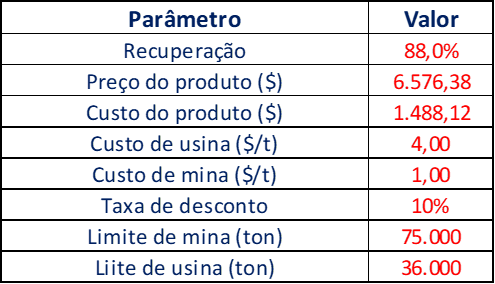

A célula abaixo define os valores dos parâmetros Taxa de desconto, Limite de mina e Limite de usina e em seguida cria duas variáveis: blocos e anos. A primeira variável refere-se a uma lista contendo os valores das identidades de cada bloco do banco de dados e a segunda refere-se uma lista contendo, em ordem crescente, do número 1 ao número de anos necessários para gerar a cava final. Neste primeiro momento a otimização acontecerá sem que haja limite de mina ou usina, por essa razão a variável anos aqui só possui o valor de 1 em sua lista (uma vez que a cava geral será gerada em apenas um ano).

In [7]:
Taxa_de_desconto = 0.1
Limite_extração = 75000
Limite_usina = 36000

blocos = ID
anos = [1] 
desconto_anual = {year: (1/((1+Taxa_de_desconto)**(year-1))) for year in anos}

A célula abaixo define o modelo a ser otimizado de acordo com a estrutura requerida pela biblioteca do otimizador Gurobi. Neste momento duas variáveis são criadas: extraído e Valor, ambas em função das variáveis blocos e anos. Em seguida são definidas as restrições operacionais:

c1 - A equação deste código diz que se um bloco for extraído num período, não poderá ser extraído novamente.

c2 - A equação deste código limita a extração de blocos num período a um determinado valor. 

c3 - A equação deste código limita o processamento de blocos num período a um determinado valor.

b3 - Ao multiplicar a variável binária pelo dicionário dici_valor (o qual contém o valor de cada bloco), tem-se o lucro por ano gerado pelos blocos que foram extraídos e processados, o qual é definido pela variável Valor.

As restrições a1 a a9 referem-se a cada posição de bloco ilustrado pelos blocos azuis na segunda proposta de precedência de blocos. Caso o tipo de precedência definido tenha sido igual a 1, os códigos referentes aos 4 blocos da situação 2 que não englobam a situação 1 são desativados. Caso o tipo de precedência definido tenha sido igual a 2, todos os 9 códigos são ativados.

In [8]:
model = gp.Model('opencastMining')

extraído = model.addVars(blocos, anos, vtype=gp.GRB.BINARY, name="extraído")
Valor = model.addVars(blocos, anos, name='valor')

c1 = model.addConstrs((gp.quicksum(extraído[b, year] for year in anos) <= 1 for b in blocos), "c1")

c2 = model.addConstrs((gp.quicksum(extraído[b, year] * dici_massa[b] for b in blocos) <= 99999999 for year in anos), 'c2')

c3 = model.addConstrs((gp.quicksum(extraído[b, year] * dici_min[b] for b in blocos) <= 99999999 for year in anos), 'c3')

b3 = model.addConstrs((gp.quicksum(extraído[b, year] * dici_valor[b] for b in blocos) == Valor[b, year] for b, year in Valor), 'b3')

a1 = model.addConstrs(((extraído[b, current_year] <= gp.quicksum(extraído[(b-area), next_year] for next_year in anos[current_index - 1 :]) for b in blocos for current_index, current_year in enumerate(anos) if b in lista_todos_valores)), 'a1')

a2 = model.addConstrs(((extraído[b, current_year] <= gp.quicksum(extraído[(b-area-1), next_year] for next_year in anos[current_index - 1 :]) for b in blocos for current_index, current_year in enumerate(anos) if b in lista_primeira_coluna)), 'a2')

a3 = model.addConstrs(((extraído[b, current_year] <= gp.quicksum(extraído[(b-area+1), next_year] for next_year in anos[current_index - 1 :]) for b in blocos for current_index, current_year in enumerate(anos) if b in lista_última_coluna)), 'a3')

a4 = model.addConstrs(((extraído[b, current_year] <= gp.quicksum(extraído[(b-area-comprimento), next_year] for next_year in anos[current_index - 1 :]) for b in blocos for current_index, current_year in enumerate(anos) if b in lista_primeira_linha)), 'a4')

a5 = model.addConstrs(((extraído[b, current_year] <= gp.quicksum(extraído[(b-area+comprimento), next_year] for next_year in anos[current_index - 1 :]) for b in blocos for current_index, current_year in enumerate(anos) if b in lista_ultima_linha)), 'a5')

if a == 2:

    a6 = model.addConstrs((extraído[b, current_year] <= gp.quicksum(extraído[(b-area-comprimento+1), next_year] for next_year in anos[current_index - 1 :]) for b in blocos for current_index, current_year in enumerate(anos) if b in lista_diag_sup_dir))

    a7 = model.addConstrs((extraído[b, current_year] <= gp.quicksum(extraído[(b-area-comprimento-1), next_year] for next_year in anos[current_index - 1 :]) for b in blocos for current_index, current_year in enumerate(anos) if b in lista_diag_sup_esq))

    a8 = model.addConstrs((extraído[b, current_year] <= gp.quicksum(extraído[(b-area+comprimento+1), next_year] for next_year in anos[current_index - 1 :]) for b in blocos for current_index, current_year in enumerate(anos) if b in lista_diag_inf_dir))

    a9 = model.addConstrs((extraído[b, current_year] <= gp.quicksum(extraído[(b-area+comprimento-1), next_year] for next_year in anos[current_index - 1 :]) for b in blocos for current_index, current_year in enumerate(anos) if b in lista_diag_inf_esq))


--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2022-07-13
Using license file C:\Users\thall\gurobi.lic


O objetivo do otimizador é encontrar o maior valor resultado da função objetivo variando o conjunto de blocos extraídos por ano. A função objetivo descrita abaixo refere-se aos somatórios de anos e blocos do produto da variável Valor pela Taxa de desconto anual.

In [9]:
extractionProfit = gp.quicksum(Valor[b, year]*desconto_anual[year] for b in blocos for year in anos)
model.setObjective(extractionProfit, sense=gp.GRB.MAXIMIZE)

O comando abaixo colocar a otimização para rodar.

In [10]:
model.optimize()

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 2842 rows, 1000 columns and 255208 nonzeros
Model fingerprint: 0xf7aca3bd
Variable types: 500 continuous, 500 integer (500 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+08]
Found heuristic solution: objective -0.0000000
Presolve removed 1451 rows and 597 columns
Presolve time: 0.17s
Presolved: 1391 rows, 403 columns, 3183 nonzeros
Found heuristic solution: objective 2.812293e+08
Variable types: 1 continuous, 402 integer (402 binary)

Root relaxation: cutoff, 130 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0      2.8123e+08 2.8123e+08  0.00%     -    0s

Explored 

O código abaixo calcula a tonelagem total necessária para gerar a cava final e a divide pela capacidade anual de extração do empreendimento. Desta forma, arredondando o valor para cima, tem-se a estimativa de vida útil da mina que é número de anos necessários para gerar a cava final.

In [11]:
blocos_extraídos_ano0 = []
for year in anos:
    for b in blocos:
        if round(extraído[b, year].X) == 1:
            if year == 1:
                blocos_extraídos_ano0.append(b)
    
ano_00 = sorted(blocos_extraídos_ano0)
soma = 0
for item in blocos_extraídos_ano0:
    n1 = Massa[item-1]
    soma = soma + n1
print('O total de massa extraída para gerar a cava final é de', soma,'toneladas. Considerando uma capacidade de lavra anual de', Limite_extração, 'toneladas, será necessário', soma//Limite_extração+1, 'anos para gerar a cava ótima da mina.')

O total de massa extraída para gerar a cava final é de 198420 toneladas. Considerando uma capacidade de lavra anual de 75000 toneladas, será necessário 3 anos para gerar a cava ótima da mina.


O algoritmo acima definiu o período necessário para gerar a cava final da mina. De posse dessa informação pôde-se rodar o modelo considerando os anos de vida útil da mina e as capacidades de mina e usina do empreendimento, como a célula abaixo propõe.

In [12]:
blocos = ID
anos = []
for y in range(soma//Limite_extração+1):
    anos.append(y+1)
limit_mine = {}
limit_process = {}
for c in range(soma//Limite_extração+1):
    limit_mine[int(anos[c])] = Limite_extração
    limit_process[int(anos[c])] = Limite_usina
desconto_anual = {year: (1/((1+Taxa_de_desconto)**(year-1))) for year in anos}

model = gp.Model('opencastMining')

extraído = model.addVars(blocos, anos, vtype=gp.GRB.BINARY, name="extraído")
Valor = model.addVars(blocos, anos, name='valor')

c1 = model.addConstrs(gp.quicksum(extraído[b, year] for year in anos) <= 1 for b in blocos)

c2 = model.addConstrs(gp.quicksum(extraído[b, year] * dici_massa[b] for b in blocos) <= limit_mine[year] for year in anos)

c3 = model.addConstrs(gp.quicksum(extraído[b, year] * dici_min[b] for b in blocos) <= limit_process[year] for year in anos)

b3 = model.addConstrs((gp.quicksum(extraído[b, year] * dici_valor[b] for b in blocos) == Valor[b, year] for b, year in Valor), 'b3')

a1 = model.addConstrs((extraído[b, current_year] <= gp.quicksum(extraído[(b-area), next_year] for next_year in anos[:current_year]) for b in blocos for current_index, current_year in enumerate(anos) if b in lista_todos_valores))

a2 = model.addConstrs((extraído[b, current_year] <= gp.quicksum(extraído[(b-area-1), next_year] for next_year in anos[:current_year]) for b in blocos for current_index, current_year in enumerate(anos) if b in lista_primeira_coluna))

a3 = model.addConstrs((extraído[b, current_year] <= gp.quicksum(extraído[(b-area+1), next_year] for next_year in anos[:current_year]) for b in blocos for current_index, current_year in enumerate(anos) if b in lista_última_coluna))

a4 = model.addConstrs((extraído[b, current_year] <= gp.quicksum(extraído[(b-area-comprimento), next_year] for next_year in anos[:current_year]) for b in blocos for current_index, current_year in enumerate(anos) if b in lista_primeira_linha))

a5 = model.addConstrs((extraído[b, current_year] <= gp.quicksum(extraído[(b-area+comprimento), next_year] for next_year in anos[:current_year]) for b in blocos for current_index, current_year in enumerate(anos) if b in lista_ultima_linha))

if a == 2:

    a6 = model.addConstrs((extraído[b, current_year] <= gp.quicksum(extraído[(b-area-comprimento+1), next_year] for next_year in anos[:current_index]) for b in blocos for current_index, current_year in enumerate(anos) if b in lista_diag_sup_dir))

    a7 = model.addConstrs((extraído[b, current_year] <= gp.quicksum(extraído[(b-area-comprimento-1), next_year] for next_year in anos[:current_index]) for b in blocos for current_index, current_year in enumerate(anos) if b in lista_diag_sup_esq))

    a8 = model.addConstrs((extraído[b, current_year] <= gp.quicksum(extraído[(b-area+comprimento+1), next_year] for next_year in anos[:current_index]) for b in blocos for current_index, current_year in enumerate(anos) if b in lista_diag_inf_dir))

    a9 = model.addConstrs((extraído[b, current_year] <= gp.quicksum(extraído[(b-area+comprimento-1), next_year] for next_year in anos[:current_index]) for b in blocos for current_index, current_year in enumerate(anos) if b in lista_diag_inf_esq))

extractionProfit = gp.quicksum(Valor[b, year]*desconto_anual[year] for b in blocos for year in anos)
model.setObjective(extractionProfit, sense=gp.GRB.MAXIMIZE)

model.setObjective(extractionProfit, sense=gp.GRB.MAXIMIZE)
model.optimize()

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 7526 rows, 3000 columns and 771144 nonzeros
Model fingerprint: 0x4f04efba
Variable types: 1500 continuous, 1500 integer (1500 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [8e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+04]
Found heuristic solution: objective -0.0000000
Presolve removed 3348 rows and 1879 columns
Presolve time: 0.52s
Presolved: 4178 rows, 1121 columns, 15124 nonzeros
Variable types: 3 continuous, 1118 integer (1118 binary)

Root relaxation: objective 3.219791e+08, 481 iterations, 0.04 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3.2198e+08    0  252   -0.00000 3.2198e+08      -     -    0s
H    0     0                    1.4

A solução do modelo é apresentada pelo algoritmo abaixo:

In [13]:
blocos_extraídos_ano1 = []
blocos_extraídos_ano2 = []
blocos_extraídos_ano3 = []

for year in anos:
    for b in blocos:
        if round(extraído[b, year].X) == 1:
            if year == 1:
                blocos_extraídos_ano1.append(b)
            if year == 2:
                blocos_extraídos_ano2.append(b)
            if year == 3:
                blocos_extraídos_ano3.append(b)
    
pilha_ano1 = []
usina_ano1 = []
for a1 in blocos_extraídos_ano1:
    if Usina[a1-1] > -2850:
        usina_ano1.append(a1)
    else:
        pilha_ano1.append(a1)
pilha_ano2 = []
usina_ano2 = []
for a2 in blocos_extraídos_ano2:
    if Usina[a2-1]*(1-Taxa_de_desconto) > -2850:
        usina_ano2.append(a2)
    else:
        pilha_ano2.append(a2)
pilha_ano3 = []
usina_ano3 = []
for a3 in blocos_extraídos_ano3:
    if Usina[a3-1]*(1-Taxa_de_desconto)*(1-Taxa_de_desconto) > -2850:
        usina_ano3.append(a3)
    else:
        pilha_ano3.append(a3)
        
print('ano 01:')
print('blocos enviados à pilha de estéril no primeiro ano:',pilha_ano1)
print('blocos enviados à usina no primeiro ano:',usina_ano1)
print('')
print('ano 02:')
print('blocos enviados à pilha de estéril no segundo ano:',pilha_ano2)
print('blocos enviados à usina no segundo ano:',usina_ano2)
print('')
print('ano 03:')
print('blocos enviados à pilha de estéril no terceiro ano:',pilha_ano3)
print('blocos enviados à usina no terceiro ano:',usina_ano3)

ano 01:
blocos enviados à pilha de estéril no primeiro ano: [35, 36, 46, 47, 53, 57, 65, 66, 75, 155, 156, 165]
blocos enviados à usina no primeiro ano: [44, 45, 54, 55, 56, 64, 145, 146, 154, 255]

ano 02:
blocos enviados à pilha de estéril no segundo ano: [26, 37, 48, 58, 59, 63, 67, 68, 74, 76, 77, 85, 86, 136, 157, 158, 164, 166, 167, 175, 176]
blocos enviados à usina no segundo ano: [147, 246, 257, 265, 266]

ano 03:
blocos enviados à pilha de estéril no terceiro ano: [16, 25, 27, 34, 38, 43, 49, 52, 126, 135, 137, 144, 148, 153, 236, 245, 254, 256]
blocos enviados à usina no terceiro ano: [247, 346, 355]


As três células abaixo exibem, respectivamente, a cava da jazida após extração dos blocos no primeiro, segundo e terceiro ano.

In [ ]:
df.drop(blocos_extraídos_ano1, inplace = True)
i_ano01 = list(df['IX'].values)
j_ano01 = list(df['IY'].values)
k_ano01 = list(df['IZ'].values)
valores_ano01 = list(df['Valor do bloco'].values)

blockModelData = {
    'x' : i_ano01,
    'y' : j_ano01,
    'z' : k_ano01,
    'var' : valores_ano01
}

blockModel = pd.DataFrame(blockModelData)
blockModel.plot3D(
    xyz_cols=('x', 'y', 'z'),
    dims=(1, 1, 1),  
    col='var',
)

In [ ]:
df.drop(blocos_extraídos_ano2, inplace = True)
i_ano02 = list(df['IX'].values)
j_ano02 = list(df['IY'].values)
k_ano02 = list(df['IZ'].values)
valores_ano02 = list(df['Valor do bloco'].values)

blockModelData = {
    'x' : i_ano02,
    'y' : j_ano02,
    'z' : k_ano02,
    'var' : valores_ano02
}

blockModel = pd.DataFrame(blockModelData)
blockModel.plot3D(
    xyz_cols=('x', 'y', 'z'),
    dims=(1, 1, 1),  
    col='var',
)

In [ ]:
df.drop(blocos_extraídos_ano3, inplace = True)
i_ano03 = list(df['IX'].values)
j_ano03 = list(df['IY'].values)
k_ano03 = list(df['IZ'].values)
valores_ano03 = list(df['Valor do bloco'].values)

blockModelData = {
    'x' : i_ano03,
    'y' : j_ano03,
    'z' : k_ano03,
    'var' : valores_ano03
}

blockModel = pd.DataFrame(blockModelData)
blockModel.plot3D(
    xyz_cols=('x', 'y', 'z'),
    dims=(1, 1, 1),  
    col='var',
)

As listas criadas abaixo dizem respeito ao resultado gerado pelo software comercial MiningMath seguindo os mesmos dados iniciais que este notebook. Assim como o notebook, o software encontrou uma solução de três anos de vida útil da mina, porém alguns dos blocos lavrados por período são diferentes.

In [ ]:
ano_01_miningmath = [35, 36, 37, 44, 45, 46, 47, 48, 54, 55, 56, 57, 58, 64, 65, 66, 67, 68, 75, 76, 77, 146, 155, 157, 166]
ano_02_miningmath = [26, 33, 34, 43, 53, 59, 63, 73, 74, 86, 136, 144, 145, 147, 154, 156, 158, 164, 165, 167, 176, 246, 255, 257, 266]
ano_03_miningmath = [16, 24, 25, 27, 28, 38, 49, 52, 78, 85, 87, 126, 135, 137, 148, 153, 175, 177, 236, 245, 247, 254, 256, 265, 346, 355]

Para efeito comparativo, as células abaixo apresentam as cavas por período de acordo com a solução gerada pelo MiningMath.

In [ ]:
df = pd.read_csv(r'C:\Users\thall\Documents\Faculdade\Iniciação_Científica\Sequenciamento\dataset5_csv.csv')
df = df[['ID', 'IX', 'IY', 'IZ', 'Teor', 'Densidade', 'Angulo', 'Massa', 'Usina', 'Pilha']]
df['Massa Processada'] = Massa_Processada
df['Valor do bloco'] = valor_bloco
ID = list(df['ID'].values)
i = list(df['IX'].values)
j = list(df['IY'].values)
k = list(df['IZ'].values)
Massa = list(df['Massa'].values)
Teor = list(df['Teor'].values)
Usina = list(df['Usina'].values)
Pilha = list(df['Pilha'].values)
index = ID
df['index'] = index
df.set_index('index', inplace = True)

In [ ]:
df.drop(ano_01_miningmath, inplace = True)
i_ano01 = list(df['IX'].values)
j_ano01 = list(df['IY'].values)
k_ano01 = list(df['IZ'].values)
valores_ano01 = list(df['Valor do bloco'].values)

blockModelData = {
    'x' : i_ano01,
    'y' : j_ano01,
    'z' : k_ano01,
    'var' : valores_ano01
}

blockModel = pd.DataFrame(blockModelData)
blockModel.plot3D(
    xyz_cols=('x', 'y', 'z'),
    dims=(1, 1, 1),  
    col='var',
)

In [ ]:
df.drop(ano_02_miningmath, inplace = True)
i_ano02 = list(df['IX'].values)
j_ano02 = list(df['IY'].values)
k_ano02 = list(df['IZ'].values)
valores_ano02 = list(df['Valor do bloco'].values)

blockModelData = {
    'x' : i_ano02,
    'y' : j_ano02,
    'z' : k_ano02,
    'var' : valores_ano02
}

blockModel = pd.DataFrame(blockModelData)
blockModel.plot3D(
    xyz_cols=('x', 'y', 'z'),
    dims=(1, 1, 1),  
    col='var',
)

In [ ]:
df.drop(ano_03_miningmath, inplace = True)
i_ano03 = list(df['IX'].values)
j_ano03 = list(df['IY'].values)
k_ano03 = list(df['IZ'].values)
valores_ano03 = list(df['Valor do bloco'].values)

blockModelData = {
    'x' : i_ano03,
    'y' : j_ano03,
    'z' : k_ano03,
    'var' : valores_ano03
}

blockModel = pd.DataFrame(blockModelData)
blockModel.plot3D(
    xyz_cols=('x', 'y', 'z'),
    dims=(1, 1, 1),  
    col='var',
)